# Metrics during GRACE era

In this notebook, we compare our TWS reconstruction to the GRACE, our target.

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.regions import basins
from deeprec.utils import ROOT_DIR

In [12]:
# Register dask progress bar
ProgressBar(minimum=5).register()


In [13]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")


## Data Preprocessing

### Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [14]:
# Load and combine our predictions
pred_dir = ROOT_DIR / "models/predictions/ensemble-mixed"

ours_list = []

for inp_name in ["era", "era-rdcd", "wghm-era"]:
    twsa_ours = xr.open_zarr(pred_dir / f"ensemble-mixed_{inp_name}_best-mae.zarr").twsa
    ours_list.append(twsa_ours.rename(f"twsa_ours_{inp_name}"))
ours = xr.merge(ours_list)


In [15]:
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
recs = xr.open_zarr(recs_store)


In [16]:
# Merge all data sets
ds_all = xr.merge([tgts, inps, ours])

# Create and apply mask (land area and Greenland+Antarctica exclusion)
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean


Specify variables of interest and their descriptive names:

In [17]:
vars_verbose = {
    "twsa_ours_era-rdcd": "DeepRec, 4×ERA5",
    "twsa_ours_era": "DeepRec, 14×ERA5",
    "twsa_ours_wghm-era": "DeepRec, WGHM+14×ERA5",
    "twsa_gap": "WGHM",
    "twsa_csr": "CSR (GRACE)",
}
eval_names = list(vars_verbose.keys())

target_name = "twsa_csr"
eval_names.remove(target_name)

## Error and correlation world maps

In [18]:
ds_grid = ds_all[[target_name, *eval_names]]
# Only evaluate GRACE time
ds_grid = ds_grid.sel(time=slice("2002", "2023")).compute()
# Remove missing time steps - remove missing time steps in GRACE for all vars
ds_grid = ds_grid.where(ds_grid.dr.time_notnull(), drop=True)


[########################################] | 100% Completed | 5.02 s
[########################################] | 100% Completed | 5.09 s


In [19]:
# Print time period
times = ds_grid.get_index("time")
print(f"Timespan: {times[0].date()} to {times[-1].date()}")


Timespan: 2002-04-01 to 2022-12-01


In [20]:
# Calculate basin averages
ds_basin: xr.Dataset = (
    # Select variables and time frame of interest
    ds_grid.chunk(time=10, lat=-1, lon=-1)
    .dr.select_basins(top=72)
    .dr.weight_lat()
    .mean(["lat", "lon"])
    .compute()
)


[########################################] | 100% Completed | 87.32 s
[########################################] | 100% Completed | 87.17 s


In [21]:
# GeoDataFrame containing basin shapes and areas
gdf_basin_shapes = basins(top=72)

# Series of basin areas
s_basin_areas = gdf_basin_shapes.rename(
    columns={"riverbasin": "region", "sum_sub_ar": "area"}
).set_index("region")["area"]

# DataArray of basin areas, for weighting
da_basin_areas = xr.DataArray.from_series(s_basin_areas)

## Split into training and validation periods

In [22]:
period_train = slice(None, "2021")
period_val = slice("2022", None)

ds_grid_train = ds_grid.sel(time=period_train)
ds_grid_val = ds_grid.sel(time=period_val)

ds_basin_train = ds_basin.sel(time=period_train)
ds_basin_val = ds_basin.sel(time=period_val)

# Get start and end years of time series
times_train = ds_basin_train.get_index("time")
times_val = ds_basin_val.get_index("time")

period_train = (times_train[0].year, times_train[-1].year)
period_val = (times_val[0].year, times_val[-1].year)

print(f"Timespan Training:   {times_train[0].date()} to {times_train[-1].date()}")
print(f"Timespan Validation: {times_val[0].date()} to {times_val[-1].date()}")

Timespan Training:   2002-04-01 to 2021-12-01
Timespan Validation: 2022-01-01 to 2022-12-01


## Calculate RMSEs

In [23]:
# RMSE
rmse_grid_train = metrics.rmse(
    ds_grid_train[target_name], ds_grid_train[eval_names], dim="time", skipna=True
)
rmse_basin_train = metrics.rmse(
    ds_basin_train[target_name], ds_basin_train[eval_names], dim="time", skipna=True
)
rmse_grid_val = metrics.rmse(
    ds_grid_val[target_name], ds_grid_val[eval_names], dim="time", skipna=True
)
rmse_basin_val = metrics.rmse(
    ds_basin_val[target_name], ds_basin_val[eval_names], dim="time", skipna=True
)

# Create new partition (part) and model dims
da_rmse_grid = xr.concat(
    [rmse_grid_train, rmse_grid_val], pd.Index(["train", "val"], name="part")
).to_dataarray("model")
da_rmse_basin = xr.concat(
    [rmse_basin_train, rmse_basin_val], pd.Index(["train", "val"], name="part")
).to_dataarray("model")

In [24]:
# Calculate global weighted averages
da_rmse_grid_avg = (
    da_rmse_grid.dr.weight_lat()
    .mean(["lat", "lon"])
    .to_dataframe(name="score")
    .reset_index()
)
da_rmse_basin_avg = (
    da_rmse_basin.weighted(da_basin_areas)
    .mean("region")
    .to_dataframe(name="score")
    .reset_index()
)

In [25]:
# For creating self-explaining text on figure legends
legend_renamer = {
    "part": "Partition",
    "train": f"Training\n({period_train[0]}--{period_train[1]})",
    "val": f"Validation\n({period_val[0]})",
}

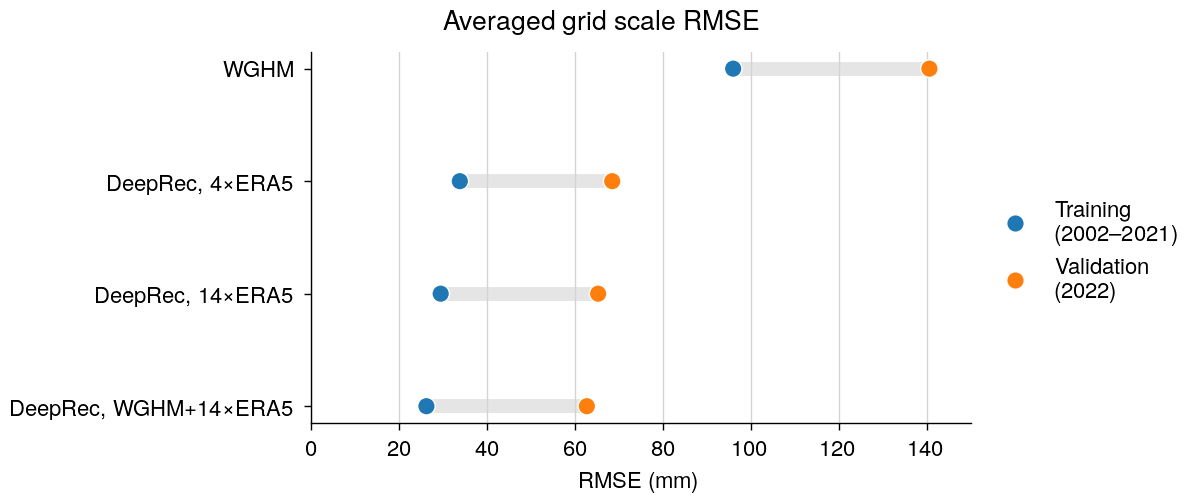

In [26]:
scatter_kwargs = dict(s=40, edgecolors="white")
hlines_kwargs = dict(color="darkgray", lw=5, zorder=0, alpha=0.3)

# Rename and order model names
model_order = (
    da_rmse_grid_avg.query("part == 'val'").sort_values("score", ascending=False).model
)
da_rmse_grid_avg.model = pd.Categorical(
    da_rmse_grid_avg.model, categories=model_order, ordered=True
).rename_categories(vars_verbose)

# Dataframe that saves smallest and largest value per model
df_minmax = da_rmse_grid_avg.groupby("model", observed=True).agg(
    {"score": ["min", "max"]}
)


fig, ax = plt.subplots(figsize=(6, 2.5))
sns.scatterplot(
    da_rmse_grid_avg, x="score", y="model", hue="part", ax=ax, **scatter_kwargs
)

# Connect the dots
ax.hlines(
    y=df_minmax.index,
    xmin=df_minmax.score["min"],
    xmax=df_minmax.score["max"],
    **hlines_kwargs,
)

ax.set(ylabel=None, xlabel="RMSE (mm)", xlim=(0, 150))
ax.xaxis.grid()
ax.legend().remove()
legend = fig.legend(loc="outside right")
# Replace legend texts
for text in legend.texts:
    t = text.get_text()
    if t in legend_renamer:
        t = legend_renamer[t]
    text.set_text(t)

fig.suptitle("Averaged grid scale RMSE", weight="bold");

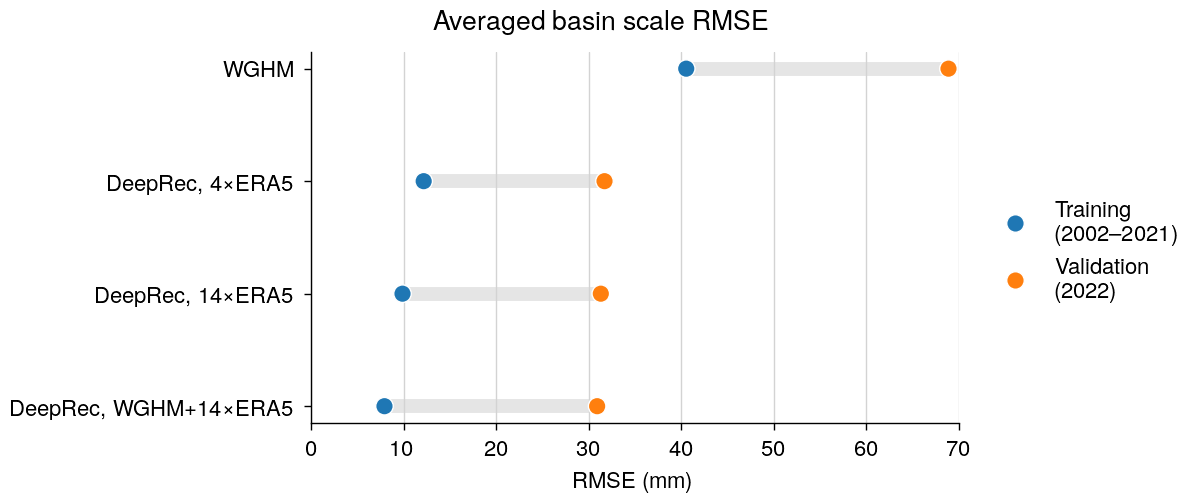

In [27]:
# Rename and order model names
model_order = (
    da_rmse_basin_avg.query("part == 'val'").sort_values("score", ascending=False).model
)
da_rmse_basin_avg.model = pd.Categorical(
    da_rmse_basin_avg.model, categories=model_order, ordered=True
).rename_categories(vars_verbose)

# Dataframe that saves smallest and largest value per model
df_minmax = da_rmse_basin_avg.groupby("model", observed=True).agg(
    {"score": ["min", "max"]}
)


fig, ax = plt.subplots(figsize=(6, 2.5))
sns.scatterplot(
    da_rmse_basin_avg, x="score", y="model", hue="part", ax=ax, **scatter_kwargs
)

# Connect the dots
ax.hlines(
    y=df_minmax.index,
    xmin=df_minmax.score["min"],
    xmax=df_minmax.score["max"],
    **hlines_kwargs,
)

ax.set(ylabel=None, xlabel="RMSE (mm)", xlim=(0, 70))
ax.xaxis.grid()
ax.legend().remove()
legend = fig.legend(loc="outside right")
# Replace legend texts
for text in legend.texts:
    t = text.get_text()
    if t in legend_renamer:
        t = legend_renamer[t]
    text.set_text(t)

fig.suptitle("Averaged basin scale RMSE", weight="bold");


In [28]:
# NSE
nse_grid_train = metrics.nse(
    ds_grid_train[target_name], ds_grid_train[eval_names], dim="time", skipna=True
)
nse_basin_train = metrics.nse(
    ds_basin_train[target_name], ds_basin_train[eval_names], dim="time", skipna=True
)
nse_grid_val = metrics.nse(
    ds_grid_val[target_name], ds_grid_val[eval_names], dim="time", skipna=True
)
nse_basin_val = metrics.nse(
    ds_basin_val[target_name], ds_basin_val[eval_names], dim="time", skipna=True
)

# Create new partition (part) and model dims
da_nse_grid = xr.concat(
    [nse_grid_train, nse_grid_val], pd.Index(["train", "val"], name="part")
).to_dataarray("model")
da_nse_basin = xr.concat(
    [nse_basin_train, nse_basin_val], pd.Index(["train", "val"], name="part")
).to_dataarray("model")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [29]:
# Calculate global weighted averages
da_nse_grid_avg = (
    da_nse_grid.dr.weight_lat()
    .mean(["lat", "lon"])
    .to_dataframe(name="score")
    .reset_index()
)
da_nse_basin_avg = (
    da_nse_basin.weighted(da_basin_areas)
    .mean("region")
    .to_dataframe(name="score")
    .reset_index()
)


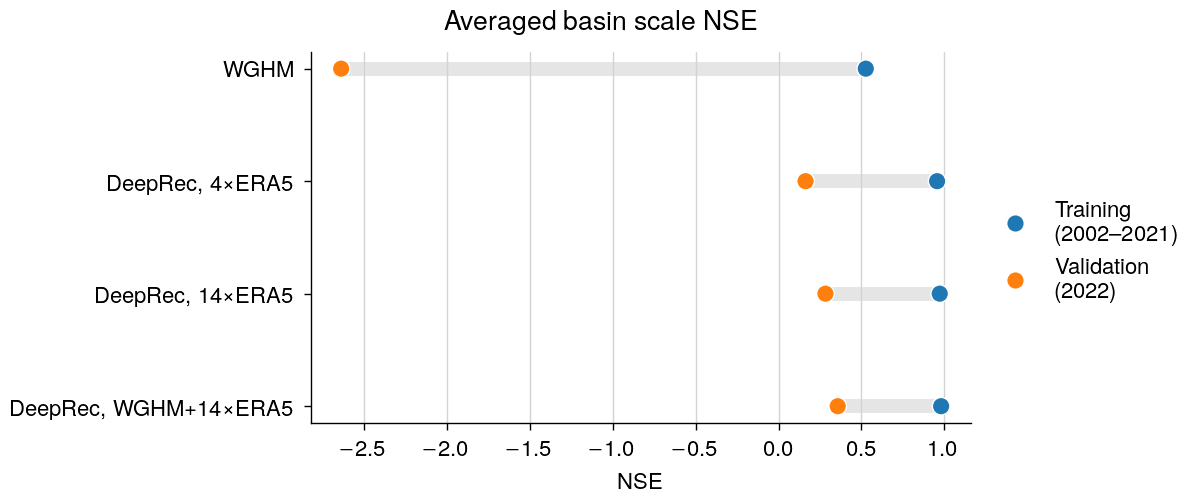

In [30]:
# Rename and order model names
model_order = (
    da_nse_basin_avg.query("part == 'val'").sort_values("score", ascending=True).model
)
da_nse_basin_avg.model = pd.Categorical(
    da_nse_basin_avg.model, categories=model_order, ordered=True
).rename_categories(vars_verbose)

# Dataframe that saves smallest and largest value per model
df_minmax = da_nse_basin_avg.groupby("model", observed=True).agg(
    {"score": ["min", "max"]}
)


fig, ax = plt.subplots(figsize=(6, 2.5))
sns.scatterplot(
    da_nse_basin_avg, x="score", y="model", hue="part", ax=ax, **scatter_kwargs
)

# Connect the dots
ax.hlines(
    y=df_minmax.index,
    xmin=df_minmax.score["min"],
    xmax=df_minmax.score["max"],
    **hlines_kwargs,
)

ax.set(ylabel=None, xlabel="NSE")  # , xlim=(, None))
ax.xaxis.grid()
ax.legend().remove()
legend = fig.legend(loc="outside right")
# Replace legend texts
for text in legend.texts:
    t = text.get_text()
    if t in legend_renamer:
        t = legend_renamer[t]
    text.set_text(t)

fig.suptitle("Averaged basin scale NSE", weight="bold");


## Map plots

In [31]:
import cmcrameri.cm as cmc

In [32]:
plot_kwargs = dict(
    vmin=-1,
    vmax=1,
    cmap=cmc.bam,
    coastlines=True,
    gridlines=True,
    rasterized=True,
    coastlines_kwargs=dict(rasterized=True, linewidth=0.5),
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.02, label="NSE"),
    figsize=(6, 8.25),
)
basinlines_kwargs = dict(
    edgecolor="black", linewidth=0.3, facecolor="None", rasterized=True, zorder=3.0
)


In [33]:
da_nse_basin = da_nse_basin.assign_coords(
    part=[legend_renamer[name] for name in da_nse_basin.part.values]
).assign_coords(model=[vars_verbose[name] for name in da_nse_basin.model.values])
da_nse_grid = da_nse_grid.assign_coords(
    part=[legend_renamer[name] for name in da_nse_grid.part.values]
).assign_coords(model=[vars_verbose[name] for name in da_nse_grid.model.values])

In [34]:
da_dummy = xr.zeros_like(da_nse_grid)


/Users/lgentn/Repositories/deeprec/.venv/lib/python3.13/site-packages/xarray/plot/facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


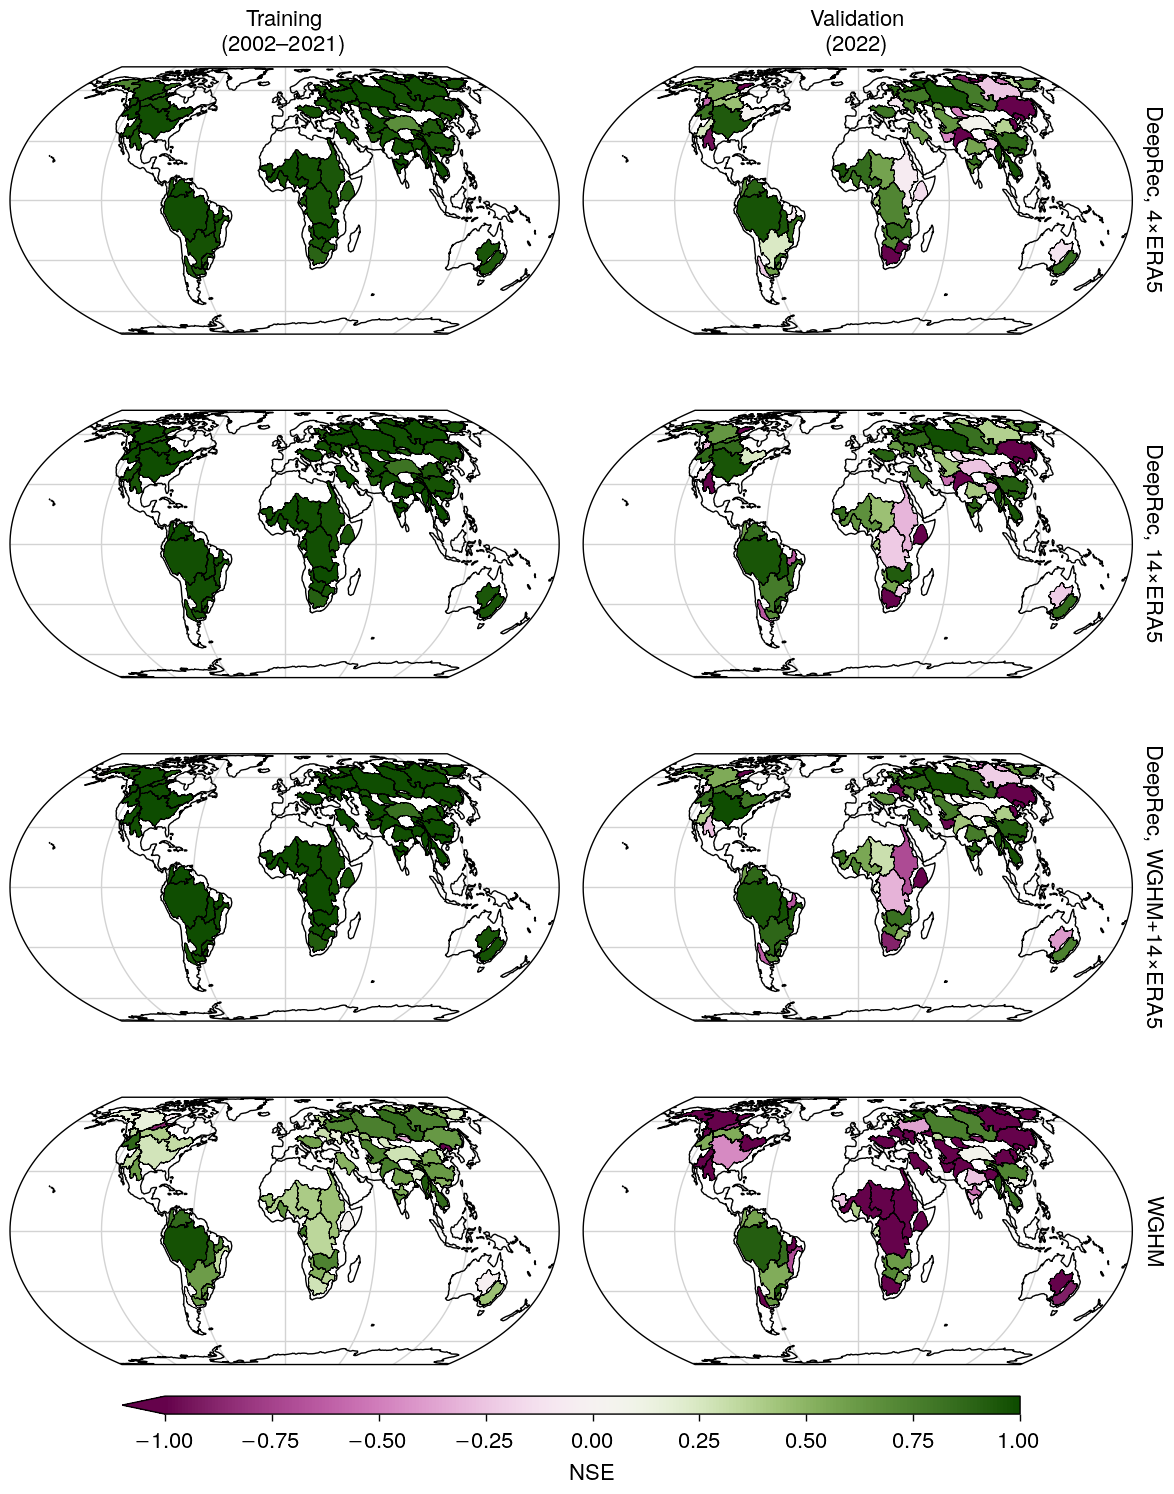

In [35]:
p = da_nse_basin.dr.projplot_basins(da_dummy, row="model", col="part", **plot_kwargs)
p.set_titles("{value}")
# Plot basin shapes
basin_shapes = basins(top=72)
for ax in p.axs.flat:
    basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)
